# Risk-Adjusted Scouting (Wingers & Attacking Midfielders)
## Notebook 01 — Player Universe Definition & Scouting EDA (Transfermarkt Backbone)

**Objective:** Build and validate a scout-ready player universe (18–25, ≥900 minutes) and produce a baseline scouting table (`scout_table_v0`) from the Transfermarkt backbone.

**Key outputs**
- `scouting_universe_base` (DuckDB table; already built by ingestion pipeline)
- `scout_table_v0` (DuckDB table; created in this notebook)
- `reports/tables/scout_table_v0_sample.csv` (lightweight sample export)

**Notes**
- This notebook focuses on scope, data quality and availability/risk proxies from public data.
- FBref performance features (Talent Score) will be integrated in Notebook 02.

## 1. Setup

In [83]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

DB_PATH = "../db/scouting.duckdb"
con = duckdb.connect(DB_PATH)

print("Connected to:", DB_PATH)

Connected to: ../db/scouting.duckdb


## 2. Load Scouting Universe (Transfermarkt-only)

We start from `scouting_universe_base`, a player-season table pre-filtered on:
- age 18–25
- season minutes ≥ 900
- attacking profiles (position/sub-position heuristic)

We validate scope, coverage and data quality before scoring.

## 3. Load Table

In [84]:
con.execute("""
CREATE OR REPLACE TABLE scouting_universe_v1 AS
SELECT *
FROM scouting_universe_base
WHERE LOWER(sub_position) IN (
    'attacking midfield',
    'left winger',
    'right winger'
);
""")

In [103]:
df = con.execute("""
SELECT
    u.*,
    p.market_value_in_eur,
    p.highest_market_value_in_eur,
    p.current_club_id,
    p.current_club_name
FROM scouting_universe_v1 u
LEFT JOIN dim_player p USING (player_id)
""").df()

df.shape

(3552, 21)

## 4) Quick overview

In [86]:
df.head(5)

,player_id,competition_id,season,games_played,season_minutes,minutes_per_game,minutes_volatility,player_name,date_of_birth,nationality,position,sub_position,foot,height_in_cm,competition_name,country_name,age,market_value_in_eur,highest_market_value_in_eur
0,47184,ES1,2012-2013,34,2201.0,64.735294,25.889254,Gabriel Torje,1989-11-22,Romania,Attack,Right Winger,both,167,laliga,Spain,24,275000,7000000
1,47285,L1,2012-2013,32,2329.0,72.781250,20.805249,Ibrahima Traoré,1988-04-21,Guinea,Attack,Right Winger,left,171,bundesliga,Germany,25,600000,6000000
2,47604,TR1,2014-2015,31,2411.0,77.774194,18.937435,Sercan Yildirim,1990-04-05,Turkey,Attack,Right Winger,right,182,super-lig,Turkey,25,50000,6500000
3,48298,L1,2012-2013,18,1512.0,84.000000,15.919939,Lars Stindl,1988-08-26,Germany,Midfield,Attacking Midfield,right,181,bundesliga,Germany,25,1000000,18000000
4,48897,DK1,2012-2013,18,1146.0,63.666667,32.810906,Ade Runsewe,1989-12-01,Nigeria,Attack,Right Winger,right,176,superligaen,Denmark,24,100000,350000


In [87]:
df["season"].value_counts().sort_index()

season
2012-2013    258
2013-2014    266
2014-2015    291
2015-2016    281
2016-2017    295
2017-2018    276
2018-2019    281
2019-2020    253
2020-2021    321
2021-2022    281
2022-2023    299
2023-2024    329
2024-2025    121
Name: count, dtype: int64

In [88]:
df[["age", "season_minutes", "games_played", "minutes_volatility", "market_value_in_eur"]].describe()

,age,season_minutes,games_played,minutes_volatility,market_value_in_eur
count,3552.000000,3552.000000,3552.000000,3552.000000,3536.0
mean,22.976351,1711.218750,26.003378,24.247331,9816463.5181
std,1.644222,566.747237,6.147121,6.887233,21009494.232537
min,18.000000,900.000000,10.000000,0.000000,10000.0
25%,22.000000,1232.750000,21.000000,20.571821,500000.0
50%,23.000000,1625.000000,26.000000,25.657346,2000000.0
75%,24.000000,2118.000000,31.000000,29.245685,9000000.0
max,25.000000,3668.000000,47.000000,37.647059,180000000.0


## 5. Universe Audit (filters + plausibility)

We validate whether the universe is consistent with our intended target:
- Age distribution (18–25)
- Minutes distribution (≥900)
- Position taxonomy and noise (Transfermarkt labels are not always clean)
- League/competition coverage across seasons

## 6. Age & minutes distributions (basic plots)

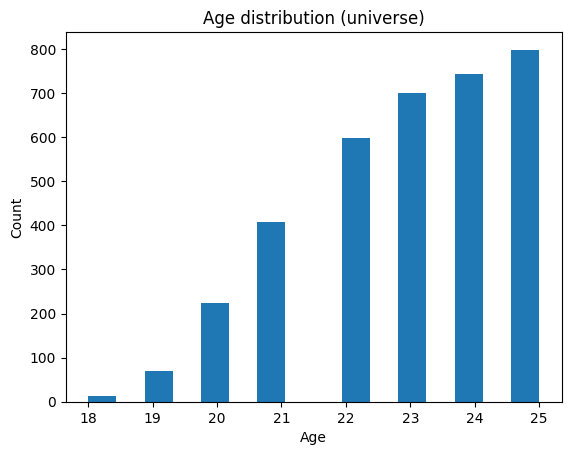

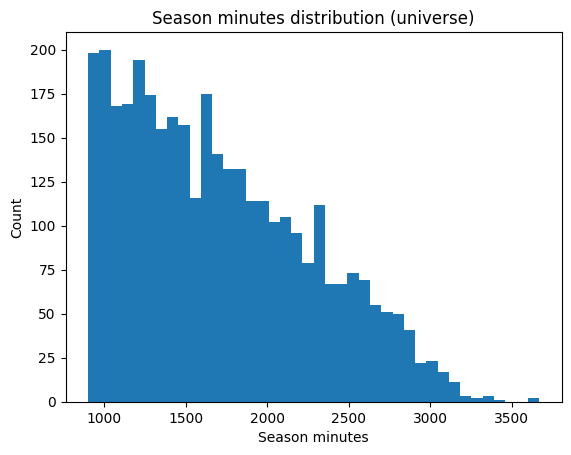

In [89]:
plt.figure()
plt.hist(df["age"].dropna(), bins=16)
plt.title("Age distribution (universe)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(df["season_minutes"].dropna(), bins=40)
plt.title("Season minutes distribution (universe)")
plt.xlabel("Season minutes")
plt.ylabel("Count")
plt.show()

## 7. Position profiling

In [90]:
df["position"].fillna("NA").value_counts().head(25)

position
Attack      2307
Midfield    1245
Name: count, dtype: int64

In [91]:
df["sub_position"].fillna("NA").value_counts().head(25)

sub_position
Attacking Midfield    1245
Left Winger           1207
Right Winger          1100
Name: count, dtype: int64

In [92]:
pd.crosstab(df["position"].fillna("NA"), df["sub_position"].fillna("NA")).iloc[:15, :15]

sub_position,Attacking Midfield,Left Winger,Right Winger
position,,,
Attack,0,1207,1100
Midfield,1245,0,0


## 8. Competition coverage

In [93]:
coverage = (
    df.groupby(["season", "competition_name", "country_name"])
      .agg(players=("player_id", "nunique"),
           rows=("player_id", "size"),
           median_minutes=("season_minutes", "median"))
      .reset_index()
      .sort_values(["season", "players"], ascending=[False, False])
)

coverage.head(30)

,season,competition_name,country_name,players,rows,median_minutes
174,2024-2025,premier-league,England,18,18,1467.5
171,2024-2025,laliga,Spain,17,17,1852.0
173,2024-2025,ligue-1,France,16,16,1611.0
169,2024-2025,eredivisie,Netherlands,13,13,1919.0
170,2024-2025,jupiler-pro-league,Belgium,10,10,1272.5
172,2024-2025,liga-portugal-bwin,Portugal,10,10,1069.0
179,2024-2025,super-lig,Turkey,10,10,1412.0
168,2024-2025,bundesliga,Germany,8,8,1072.5
176,2024-2025,premier-liga,Ukraine,8,8,1072.5
177,2024-2025,scottish-premiership,Scotland,4,4,1038.5


Plot players by competition for latest seasons:

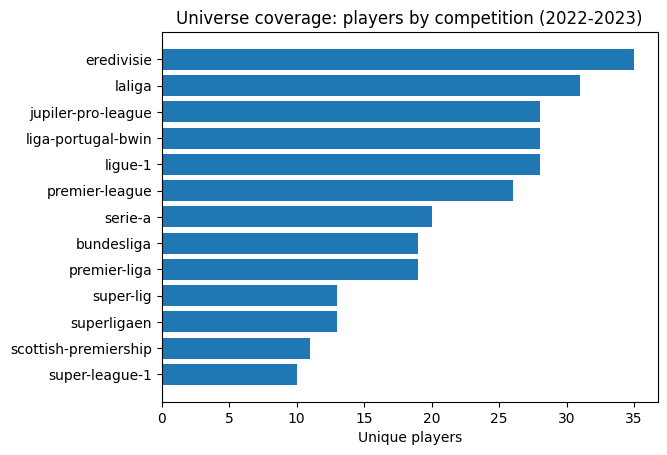

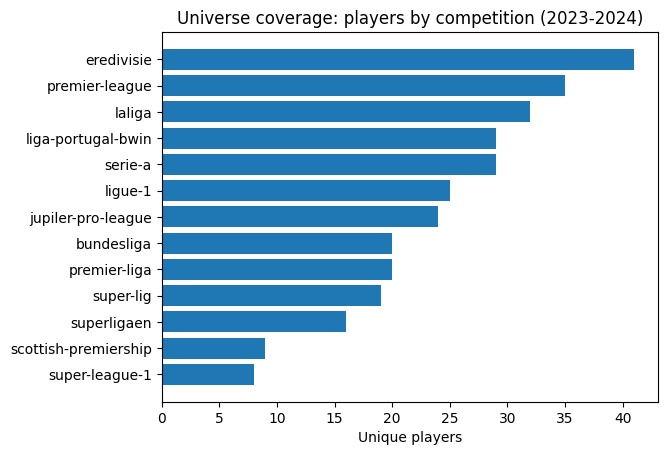

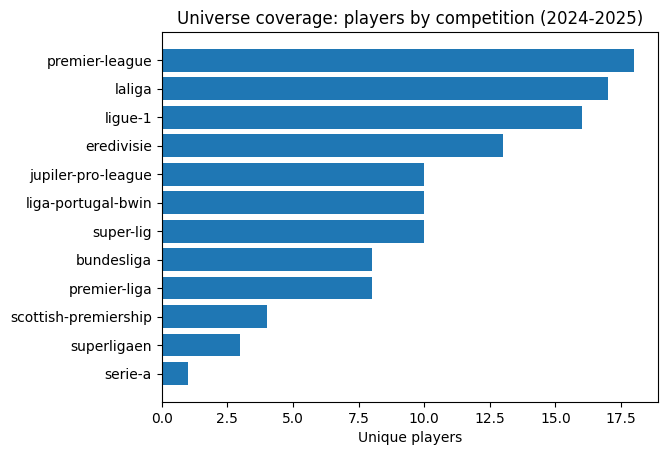

In [94]:
latest_seasons = sorted(df["season"].unique())[-3:]
tmp = coverage[coverage["season"].isin(latest_seasons)].copy()

for s in latest_seasons:
    t = tmp[tmp["season"] == s].sort_values("players", ascending=False).head(15)
    plt.figure()
    plt.barh(t["competition_name"], t["players"])
    plt.title(f"Universe coverage: players by competition ({s})")
    plt.xlabel("Unique players")
    plt.gca().invert_yaxis()
    plt.show()

## 9. Availability / Risk proxy EDA

We do not use GPS data. As an interpretable proxy for physical load and availability risk, we analyse:
- Season minutes (load proxy)
- Minutes volatility (in-match minutes variability proxy)
- Minutes per game (usage proxy)

These are **not** mixed into performance metrics and will remain a separate overlay.

## 10. Risk proxy diagnostics

In [95]:
df["season_minutes"].quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50    1625.00
0.75    2118.00
0.90    2556.80
0.95    2758.35
0.99    3053.98
Name: season_minutes, dtype: float64

In [96]:
df["minutes_volatility"].replace([np.inf, -np.inf], np.nan).dropna().describe()

count    3552.000000
mean       24.247331
std         6.887233
min         0.000000
25%        20.571821
50%        25.657346
75%        29.245685
max        37.647059
Name: minutes_volatility, dtype: float64

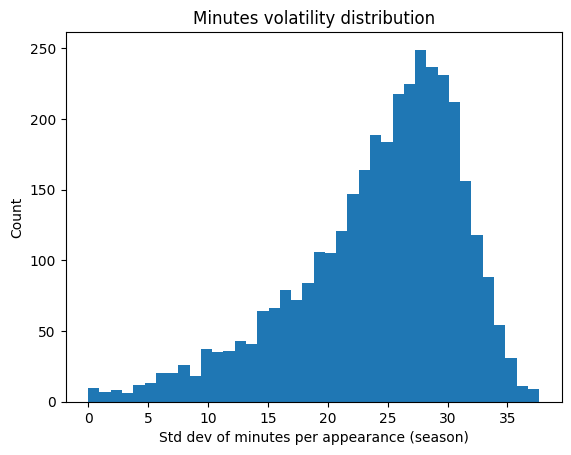

In [97]:
plt.figure()
plt.hist(df["minutes_volatility"].replace([np.inf, -np.inf], np.nan).dropna(), bins=40)
plt.title("Minutes volatility distribution")
plt.xlabel("Std dev of minutes per appearance (season)")
plt.ylabel("Count")
plt.show()

Show examples:

In [98]:
df2 = df.copy()
df2["load_p95_flag"] = df2.groupby("season")["season_minutes"].transform(lambda x: x >= x.quantile(0.95))
df2["load_p95_flag"].value_counts()

load_p95_flag
False    3366
True      186
Name: count, dtype: int64

In [99]:
df2[df2["load_p95_flag"]].sort_values(["season", "season_minutes"], ascending=[False, False]).head(15)[
    ["player_name", "season", "competition_name", "age", "season_minutes", "games_played", "minutes_volatility"]
]

,player_name,season,competition_name,age,season_minutes,games_played,minutes_volatility
3239,Aimar Oroz,2024-2025,laliga,24,2983.0,37,16.096586
2949,Mason Greenwood,2024-2025,ligue-1,24,2818.0,34,14.672433
3075,Sem Steijn,2024-2025,eredivisie,24,2772.0,33,12.348476
3432,Alberto Moleiro,2024-2025,laliga,22,2728.0,35,16.789355
2938,Evann Guessand,2024-2025,ligue-1,24,2575.0,33,23.198073
3108,Dilane Bakwa,2024-2025,ligue-1,23,2513.0,30,12.327972
3214,Jude Bellingham,2024-2025,laliga,22,2493.0,31,18.976682
2596,Morgan Gibbs-White,2023-2024,premier-league,24,3162.0,37,12.562481
3267,Matías Soulé,2023-2024,serie-a,21,3141.0,36,5.246030
2840,Fisayo Dele-Bashiru,2023-2024,super-lig,23,3043.0,36,14.712969


## 11. Market Value Sanity Checks

Market value is used as a **proxy** for cost/market perception (not a true price).
At this stage we:
- examine distribution (log-scale)
- run simple sanity correlations with age/minutes as plausibility checks

Full value-efficiency modelling will come after Talent Score integration.

## 12. Market value distribution + log

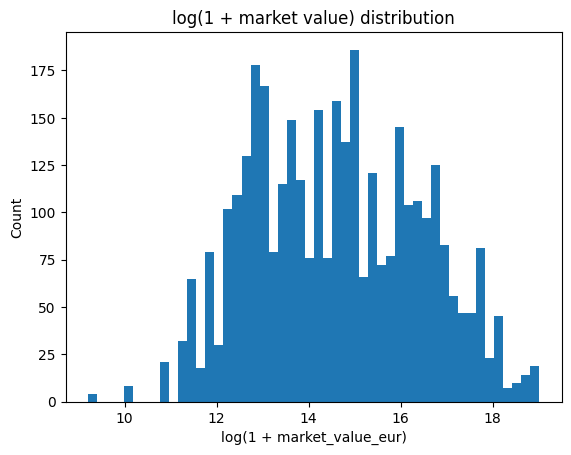

count             3536.0
mean        9816463.5181
std      21009494.232537
min              10000.0
25%             500000.0
50%            2000000.0
75%            9000000.0
max          180000000.0
Name: market_value_in_eur, dtype: Float64

In [100]:
mv = df["market_value_in_eur"].replace([np.inf, -np.inf], np.nan).dropna()
plt.figure()
plt.hist(np.log1p(mv), bins=50)
plt.title("log(1 + market value) distribution")
plt.xlabel("log(1 + market_value_eur)")
plt.ylabel("Count")
plt.show()

mv.describe()

Basic correlations (very rough; not causal):

In [101]:
tmp = df[["age", "season_minutes", "minutes_volatility", "market_value_in_eur"]].copy()
tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()
tmp.corr(numeric_only=True)

,age,season_minutes,minutes_volatility,market_value_in_eur
age,1.000000,0.083770,-0.097098,-0.167988
season_minutes,0.083770,1.000000,-0.522642,0.165242
minutes_volatility,-0.097098,-0.522642,1.000000,-0.108472
market_value_in_eur,-0.167988,0.165242,-0.108472,1.000000


## 13. Build `scout_table_v0` (Transfermarkt-only baseline)

We create a clean scouting table that:
- preserves identifiers for later joins (FBref integration)
- includes demographic and availability proxies
- includes a market value snapshot (proxy)

This table is the baseline input for subsequent scoring notebooks.

## 14. Construct and persist scout_table_v0

In [104]:
scout_table_v0 = df[[
    "player_id","player_name",
    "season","competition_id","competition_name","country_name",
    "age",
    "position","sub_position",
    "nationality","foot","height_in_cm",
    "current_club_id","current_club_name",
    "games_played","season_minutes","minutes_per_game","minutes_volatility",
    "market_value_in_eur","highest_market_value_in_eur"
]].copy()

scout_table_v0.shape

(3552, 20)

Persist to DuckDB

In [105]:
con.register("scout_table_v0_df", scout_table_v0)
con.execute("CREATE OR REPLACE TABLE scout_table_v0 AS SELECT * FROM scout_table_v0_df")
con.unregister("scout_table_v0_df")

con.execute("SELECT COUNT(*) FROM scout_table_v0").fetchone()

(3552,)

Export sample:

In [106]:
import os
os.makedirs("../reports/tables", exist_ok=True)
scout_table_v0.sample(200, random_state=42).to_csv("../reports/tables/scout_table_v0_sample.csv", index=False)

## 15. Next Steps

Next notebook will integrate FBref performance metrics to construct:
- league-season standardised features (z-scores)
- Talent Score v1 (interpretable composite)
- initial validation vs market value (sanity)

Then we will add:
- Development Score
- Physical Risk overlay (kept separate)
- Risk-adjusted composite and value-efficiency
- Budget-constrained shortlist simulation

## 16. Close connection

In [ ]:
con.close()
print("Done.")

## 17. Executive Conclusions — Player Universe Validation

### Universe definition

The refined scouting universe contains **3,552 player-seasons** across multiple leagues, restricted to:

- Age: 18–25  
- Minimum 900 season minutes  
- Roles: Attacking Midfield, Left Winger, Right Winger  

The positional taxonomy is internally consistent:
- Wingers are classified under "Attack"
- Attacking Midfielders under "Midfield"

This confirms structural integrity of the player pool.

---

### Load and availability profile

Season minute distribution is healthy:
- Median ≈ 1,625 minutes  
- 90th percentile ≈ 2,557 minutes  
- 99th percentile ≈ 3,054 minutes  

No extreme outliers or structural bias were detected.

Minutes volatility behaves logically:
- Higher season minutes → lower volatility (−0.52 correlation)
- No structural distortion across seasons

The availability proxy is usable for risk overlay modelling.

---

### Market value sanity checks

Market value distribution is right-skewed, as expected in football markets:
- Median ≈ €2M
- Mean ≈ €9.8M
- Max ≈ €180M

Correlations with age and minutes are modest:
- Minutes vs value: +0.16
- Age vs value: −0.17

This suggests the dataset is not trivially explaining market value and leaves modelling headroom for performance-based scoring.

---

### Strategic assessment

The current universe is:

✔ Cohesive  
✔ Role-consistent  
✔ Age-targeted  
✔ Statistically stable  
✔ Suitable for multi-objective modelling  

This forms a valid backbone for constructing:

- Talent Score  
- Development Score  
- Physical Risk Overlay  
- Risk-adjusted composite ranking  

Next step: integrate performance data (FBref) to construct league-normalised performance features.